<a href="https://colab.research.google.com/github/87tana/Image-Segmentation/blob/main/Tumor_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [4]:
cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


In [5]:
# Path to the JSON file
train_annotations_path = 'Tumor_Segmentation/train/_annotations.coco.json'
valid_annotations_path = 'Tumor_Segmentation/valid/_annotations.coco.json'
test_annotations_path = 'Tumor_Segmentation/test/_annotations.coco.json'

# Path to image directories
train_img_path = 'Tumor_Segmentation/train'
valid_img_path = 'Tumor_Segmentation/valid'
test_img_path = 'Tumor_Segmentation/test'

In [21]:
import os
import json
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cv2
import skimage  # import scikit_image
import tifffile  # for reading and writing TIFF
import shutil #Higher-level interface for file operations, including file copying, removal, and archiving


In [7]:
with open(valid_annotations_path,'r') as file:
   data = json.load(file)


In [8]:
id=1
print(data['images'][id]['file_name'])
print(data['images'][id]['width'])
print(data['images'][id]['height'])
print(data['annotations'][id]['category_id'])
print(data['annotations'][id]['segmentation'][0])



2422_jpg.rf.59a35b6d8d2eed150af8535cf09bbde5.jpg
640
640
1
[380, 326.25, 235, 326.25, 235, 475, 380, 475, 380, 326.25]


In [9]:
len(data['images'])

429

In [128]:
file_name = []
width = []
height = []
category_id = []
segmentation = []
subset = []

for s in ['train', 'valid', 'test']:
  with open('Tumor_Segmentation/'+s+'/_annotations.coco.json','r') as file:
    data = json.load(file)
    for id in range(len(data['images'])):
      # Flag to check the annotation availability
      ann_available=False
      # Look for the corresponding annotation
      for j in range(id,len(data['images'])):
        if data['annotations'][j]['image_id'] == data['images'][id]['id']:
          category_id.append(data['annotations'][j]['category_id'])
          segmentation.append(data['annotations'][j]['segmentation'])
          ann_available=True
          break

      if ann_available:
        file_name.append(data['images'][id]['file_name'])
        width.append(data['images'][id]['width'])
        height.append(data['images'][id]['height'])
        subset.append(s)
      else:
        print(f'Annotation is missing for image {id} in {s}')



dic = {'file_name': file_name, 'width': width , 'height': height,\
        'category_id': category_id, 'segmentation': segmentation, 'subset': subset}



Annotation is missing for image 1380 in train


In [130]:
df = pd.DataFrame.from_dict(dic)
df

,file_name,width,height,category_id,segmentation,subset
0,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg,640,640,1,"[[313.75, 238.75, 145, 238.75, 145, 401.25, 31...",train
1,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg,640,640,1,"[[342.5, 176.25, 193.75, 176.25, 193.75, 410, ...",train
2,2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg,640,640,1,"[[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295,...",train
3,2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg,640,640,1,"[[383.75, 357.5, 245, 357.5, 245, 523.75, 383....",train
4,2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg,640,640,1,"[[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5...",train
...,...,...,...,...,...,...
2140,2456_jpg.rf.fbc4e1bf546033f504b0adbf5959bb50.jpg,640,640,1,"[[407.5, 251.25, 180, 251.25, 180, 452.5, 407....",test
2141,1361_jpg.rf.d77d067dfc6aa94df76a98a34bea8ed5.jpg,640,640,2,"[[297.5, 275, 202.5, 275, 202.5, 390, 297.5, 3...",test
2142,1058_jpg.rf.f6d6dcde9564c091b30eb6873641ba36.jpg,640,640,2,"[[423.75, 276.25, 352.5, 276.25, 352.5, 352.5,...",test
2143,2817_jpg.rf.eeb513c4ab3414fdda2bbba660318b57.jpg,640,640,1,"[[281.25, 386.25, 157.5, 386.25, 157.5, 530, 2...",test


In [14]:
"""
def create_mask(image_info,annotations,output_folder,max_print=3):
  mask_np =np.zeros((image_info['height'],image_info['width']),dtype=np.uint8)
  obj_number =1
  printed_masks =0;
   for ann in annotations:
      if image_info['id'] == ann['image_id']:
          for seg_idx ,seg in enumerate(ann['segmentation']):
              rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
              seg_mask = np.zeros_like(mask_np,dtype=np.uint8)
              seg_mask[rr,cc]=255
              mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
              tifffile.imwrite(mask_path, seg_mask)
              printed_masks += 1
              if printed_masks >= max_print:
                  return  # Exit the function if maximum number of masks to print is reached
"""

In [131]:
def create_mask(image_info):
  mask_np =np.zeros((image_info['height'],image_info['width']),dtype=np.uint8)
  obj_number =1
  for seg_idx ,seg in enumerate(image_info['segmentation']):
      rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
      mask_np[rr,cc]=1

  return mask_np






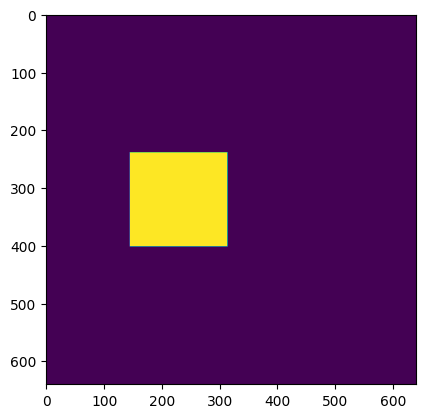

In [132]:
mask = create_mask(df.loc[0])
plt.imshow(mask)

In [35]:
df.loc[0]

file_name        2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg
width                                                         640
height                                                        640
category_id                                                     1
segmentation    [313.75, 238.75, 145, 238.75, 145, 401.25, 313...
subset                                                      train
Name: 0, dtype: object

In [47]:
np.array(df.loc[0]['segmentation']).astype(int)

array([313, 238, 145, 238, 145, 401, 313, 401, 313, 238])